# Network Visualization (PyTorch)

In [13]:
'''
import torch
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import random

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
'''
from __future__ import print_function, division

import pickle
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
from PIL import Image
import time
import copy
import shutil
%matplotlib inline
from torchvision import  transforms

In [14]:
use_gpu = True
# dtype = torch.cuda.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

# ResNet Model

Run cell below if you want to create the heat maps for the ResNets

In [25]:
class Resnet34_only(nn.Module):
   
    NUM_VID_FEATURES = 128
    NUM_PARTITIONS = 10
    NUM_CLASS = 5
    NUM_IMG_SIZE = 256
    NUM_CHANNEL = 3
    
    def __init__(self):        
        super(Resnet34_only, self).__init__()
        self.videoBranch = self._createVideoBranch()
        self.droupout = nn.Dropout(p=0.35)
        self.fc = nn.Linear(self.NUM_VID_FEATURES,self.NUM_CLASS)
        self.sigmoid = nn.Sigmoid()
        
    def _createVideoBranch(self):
        model_pretrained = torchvision.models.resnet34(pretrained=True)
        # All of the parameters are freezed, not to change (newly constructed layers' params won't be influenced)
        for param in model_pretrained.parameters():
            param.requires_grad = False   
        model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, self.NUM_VID_FEATURES)
        return model_pretrained
    
    def forward(self, x):
        x = self.videoBranch(x)
        x = self.droupout(x)
        x = self.fc(x)
        x = self.sigmoid(x) #(N,5)
        return x   

modelCheckpointPath = '../resNetExperiments/resnet_for_rnn/ResNet34_ONLY_experiment_L2_dropout/checkpoint.pth.tar'
model = Resnet34_only().type(gpu_dtype)
criterion = nn.MSELoss().type(gpu_dtype)
print("=> loading checkpoint '{}'".format(modelCheckpointPath))
checkpoint = torch.load(modelCheckpointPath)
model.load_state_dict(checkpoint['state_dict'])
# model = model.float()
print("=> loaded checkpoint '{}' (epoch {})".format(modelCheckpointPath, checkpoint['epoch']))

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters(): # This is probably fine to do as well
    param.requires_grad = False 
    
plottingLSTM=False
import resNetDataBaseAccess

=> loading checkpoint '../resNetExperiments/resnet_for_rnn/ResNet34_ONLY_experiment_L2_dropout/checkpoint.pth.tar'
=> loaded checkpoint '../resNetExperiments/resnet_for_rnn/ResNet34_ONLY_experiment_L2_dropout/checkpoint.pth.tar' (epoch 106)


# LSTM Model
Run cell below if you want to compute heat maps for LSTM model

In [15]:
class AudioVisualLSTM(nn.Module):
    NUM_AUDIO_INPUT = 68
    NUM_VID_FEATURES = 128
    NUM_AUDIO_FEATURES = 32
    NUM_LSTM_HIDDEN = 128
    NUM_PARTITIONS = 10
    NUM_CLASS = 5
    NUM_IMG_SIZE = 256
    NUM_CHANNEL = 3
    
    def __init__(self):        
        super(AudioVisualLSTM, self).__init__()
        self.audioBranch =  nn.Sequential(nn.Linear(self.NUM_AUDIO_INPUT,self.NUM_AUDIO_FEATURES))
        self.videoBranch = self._createVideoBranch()
        self.video_dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(
            input_size=(self.NUM_VID_FEATURES+self.NUM_AUDIO_FEATURES),
            hidden_size=self.NUM_LSTM_HIDDEN,
            num_layers=1,
            bias=True,
            batch_first=True # input and output tensors provided as (batch, seq, feature)
            # can add dropout later
            )
        self.fc = nn.Linear(self.NUM_LSTM_HIDDEN,self.NUM_CLASS)
        self.sigmoid = nn.Sigmoid()
        self.avg = nn.AvgPool1d(self.NUM_PARTITIONS,self.NUM_PARTITIONS)

    def _createVideoBranch(self):
        model_pretrained = torchvision.models.resnet34(pretrained=True)
        # All of the parameters are freezed, not to change (newly constructed layers' params won't be influenced)
        for param in model_pretrained.parameters():
            param.requires_grad = False   
        model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, self.NUM_VID_FEATURES)
        return model_pretrained
    
    def forward(self, x):
        videoData = x[0].view(-1,self.NUM_CHANNEL,self.NUM_IMG_SIZE,self.NUM_IMG_SIZE)
        audioData = x[1].view(-1,self.NUM_AUDIO_INPUT)
        videoProcessed = self.videoBranch(videoData).view(-1,self.NUM_PARTITIONS,self.NUM_VID_FEATURES) # will output a (n x partitions)x 32 tensor
        videoProcessed = self.video_dropout(videoProcessed)
        audioProcessed = self.audioBranch(audioData).view(-1,self.NUM_PARTITIONS,self.NUM_AUDIO_FEATURES)# will output a (n x partitions)x 128 tensor
        x = torch.cat((videoProcessed, audioProcessed), 2).type(gpu_dtype) #(N,10,160)
        h0 = Variable(torch.zeros(1, x.size()[0], self.NUM_LSTM_HIDDEN)).type(gpu_dtype)
        c0 = Variable(torch.zeros(1, x.size()[0], self.NUM_LSTM_HIDDEN)).type(gpu_dtype)
        x,cn = self.lstm(x, (h0, c0))
        x = x.contiguous().view(-1,self.NUM_LSTM_HIDDEN)
        x = self.fc(x)
        x = self.sigmoid(x) #(N*P,5)
        x = self.avg(x.view(-1,self.NUM_PARTITIONS,self.NUM_CLASS).transpose(1,2)).squeeze() #(N,5)
        return x
    
modelCheckpointPath = '../resNetExperiments/resnet_for_rnn/avepool_dropout_L2loss_ResNet34_LSTM_experiment/checkpoint.pth.tar'
model = model = AudioVisualLSTM().type(gpu_dtype)
print("=> loading checkpoint '{}'".format(modelCheckpointPath))
checkpoint = torch.load(modelCheckpointPath)
model.load_state_dict(checkpoint['state_dict'])
# model = model.float()
print("=> loaded checkpoint '{}' (epoch {})".format(modelCheckpointPath, checkpoint['epoch']))

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters(): # This is probably fine to do as well
    param.requires_grad = False 
    
plottingLSTM=True
import lstmDataBaseAccess


=> loading checkpoint '../resNetExperiments/resnet_for_rnn/avepool_dropout_L2loss_ResNet34_LSTM_experiment/checkpoint.pth.tar'
=> loaded checkpoint '../resNetExperiments/resnet_for_rnn/avepool_dropout_L2loss_ResNet34_LSTM_experiment/checkpoint.pth.tar' (epoch 72)
processing dataset: /home/noa_glaser/dataBig/train-frames/train


# Saliency Maps

### Imports

Run the first cell when you start the instance, if you change either \*DataBaseAccess file,
you will need to run the second cell

In [ ]:
# In case you need to refresh the two files, pick the one you need 
# import importlib
# resNetDataBaseAccess = importlib.reload(resNetDataBaseAccess)
# lstmDataBaseAccess = importlib.reload(lstmDataBaseAccess)

In [44]:
torch.zeros(5).long()


 0
 0
 0
 0
 0
[torch.LongTensor of size 5]

In [31]:
def compute_show_saliency_maps_ResNet(numImages, personalities, data): # for now assuming numImages < batch size 
    numPersonalities = len(personalities)

    if(data == None):
        input_images, target_var = resNetDataBaseAccess.returnSampleDataBatch() # _ is 'target'
        print(input_images.size())
        return
    else:
        input_images, _ , target_var = data
        input_images = input_images.view(-1,10,3,256,256)
        images_np = input_images.numpy()
#         images_np = images_np.transpose((1,0,2,3,4))
        print(images_np.shape)      
        select = (np.random.rand(numImages)*10).astype(np.int32)
        images_np = images_np[np.arange(numImages), select] 
        print(images_np.shape)
#         selected_indexes = torch.ones(numImages)
#         selected_indexes.random_(0,10)
#         input_images_selected = input_images.gather(1,selected_indexes.long().view(1,numImages,1,1,1)).squeeze()

        input_images = torch.from_numpy(images_np)
        
#     input_images = input_images[:numImages,:,:,:]
    imagesVar = Variable(input_images.type(gpu_dtype),requires_grad=True)
    output = model(imagesVar)
    input_images = input_images.view(-1,3,256,256)

    for img in range(numImages):
        inp = input_images[img].cpu().numpy().transpose((1, 2, 0)) 
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        plt.subplot(numImages, numPersonalities +1,1 + img*(numPersonalities +1))
        plt.axis('off')
        plt.imshow(inp)
                
    for p in range(numPersonalities):
        for sample_indx in range(output.size()[0]):
            output[sample_indx,p].backward(retain_variables=True )
            input_grad = imagesVar.grad.data.abs()
            saliency = input_grad.max(dim=1)[0].squeeze() # zero because the second one is indexes where max was found 
            saliency = saliency[sample_indx,:].cpu().numpy()
            plt.subplot(numImages,numPersonalities + 1, p+2  + sample_indx*(numPersonalities +1))

            plt.imshow(saliency, cmap=plt.cm.hot)
            if(sample_indx == 0):
                plt.title(personalities[p])
            plt.axis('off')
            plt.gcf().set_size_inches(12, 5*4)

    plt.show()

(8, 10, 3, 256, 256)
(8, 3, 256, 256)


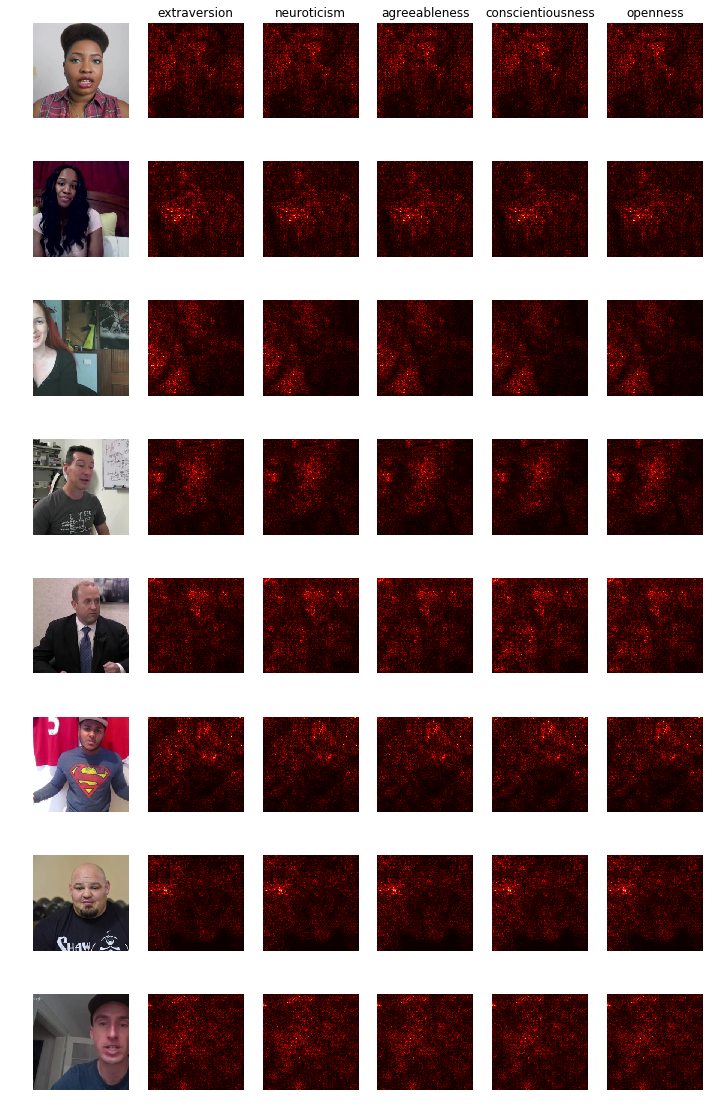

In [32]:
compute_show_saliency_maps(8,(input_images,input_audio, target_var), LSTM=False) # 8 here is actually meaningless
# (input_images,input_audio, target_var)

In [16]:
def compute_show_saliency_maps_lstm(numImages, personalities, data): # for now assuming numImages < batch size 
    def _manyImagesToColumn(images):
        return np.concatenate([images[i,:] for i in range(images.shape[0]) ], axis=0)

    numPersonalities = len(personalities)

    input_images,input_audio, _ = lstmDataBaseAccess.returnSampleDataBatch() # _ is 'target'
    input_images = input_images[:numImages,:,:,:]
    input_audio = input_audio[:numImages,:]
    imagesVar = Variable(input_images.type(gpu_dtype),requires_grad=True)
    audioVar = Variable(input_audio.type(gpu_dtype))
    # compute output
    output = model([imagesVar,audioVar])
    input_images = input_images.view(-1,3,256,256)

    numInBatch = 10 # later make more generalizable

    for img in range(numImages):
        inp = input_images[img*numInBatch:(img+1)*numInBatch].cpu().numpy().transpose((0,2,3,1)) 
        # note , will be 10x3x255x255
        inp = _manyImagesToColumn(inp)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        plt.subplot(numImages, numPersonalities +1,1 + img*(numPersonalities +1))
        plt.axis('off')
        print('inp size {0}'.format(inp.shape))
        plt.imshow(inp)
                
    for p in range(numPersonalities):
        for sample_indx in range(output.size()[0]):
            output[sample_indx,p].backward(retain_variables=True )
            input_grad = imagesVar.grad.data.abs() # size for LSTM 4, 30, 256, 256
            input_grad = input_grad.view(-1,3,256,256)
            saliency = input_grad.max(dim=1)[0].squeeze() # zero because the second one is indexes where max was found 
            saliency = saliency[numInBatch*sample_indx:numInBatch*(sample_indx+1),:].cpu().numpy()                
            saliency = _manyImagesToColumn(saliency)
            plt.subplot(numImages,numPersonalities + 1, p+2  + sample_indx*(numPersonalities +1))

            plt.imshow(saliency, cmap=plt.cm.hot)
            if(sample_indx == 0):
                plt.title(personalities[p])
            plt.axis('off')
            plt.gcf().set_size_inches(12, 5*numInBatch)

    plt.show()

In [17]:
def compute_show_saliency_maps(numImages, data, LSTM=True): # for now assuming numImages < batch size 
    model.eval() 
    personalities = ['extraversion','neuroticism','agreeableness','conscientiousness','openness']

    if(LSTM):
        compute_show_saliency_maps_lstm(numImages, personalities, data)
    else:
        compute_show_saliency_maps_ResNet(numImages, personalities, data)


In [19]:
compute_show_saliency_maps(4, LSTM=plottingLSTM)

TypeError: compute_show_saliency_maps() missing 1 required positional argument: 'data'

In [20]:
criterion = nn.MSELoss().type(gpu_dtype)
    
def compute_show_saliency_maps_lstm_justLoss(numImages, data): # for now assuming numImages < batch size 
    def _manyImagesToColumn(images):
        return np.concatenate([images[i,:] for i in range(images.shape[0]) ], axis=1)

    if(data == None):
        input_images,input_audio, target_var = lstmDataBaseAccess.returnSampleDataBatch() # _ is 'target'
    else:
        input_images,input_audio, target_var = data
    input_images = input_images[:numImages,:,:,:]
    input_audio = input_audio[:numImages,:]
    imagesVar = Variable(input_images.type(gpu_dtype),requires_grad=True)
    audioVar = Variable(input_audio.type(gpu_dtype))
    # compute output
    output = model([imagesVar,audioVar])
    outPutSum = torch.sum(output, dim=1)
#     print('outPutSum {0}'.format(outPutSum))
#     loss = criterion(output, target_var)
#     loss.backwards()
    
    input_images = input_images.view(-1,3,256,256)

    numInBatch = 10 # later make more generalizable
        
    for sample_indx in range(numImages):
        outPutSum[sample_indx].backward(retain_variables=True )
#         print('grad {0}'.format(imagesVar.grad))
        input_grad = imagesVar.grad.data.abs() # size for LSTM 4, 30, 256, 256
        input_grad = input_grad.view(-1,3,256,256)
        saliency_full = input_grad.max(dim=1)[0].squeeze() # zero because the second one is indexes where max was found 
        
        inp = input_images[sample_indx*numInBatch:(sample_indx+1)*numInBatch].cpu().numpy().transpose((0,2,3,1)) 
        # note , will be 10x3x255x255
        inp = _manyImagesToColumn(inp)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        plt.subplot(numImages*2, 1,sample_indx*2+1)
        plt.axis('off')
#         print('inp size {0}'.format(inp.shape))
        plt.imshow(inp)
                
#     for p in range(numPersonalities):
#     for sample_indx in range(output.size()[0]):
#         output[sample_indx,p].backward(retain_variables=True )
        saliency = saliency_full[numInBatch*sample_indx:numInBatch*(sample_indx+1),:].cpu().numpy()                
        saliency = _manyImagesToColumn(saliency)
        plt.subplot(numImages*2,1, sample_indx*2+2)

        plt.imshow(saliency, cmap=plt.cm.hot)
#         if(sample_indx == 0):
#             plt.title(personalities[p])
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5*2*2)

    plt.show()

In [ ]:
compute_show_saliency_maps_lstm_justLoss(8)

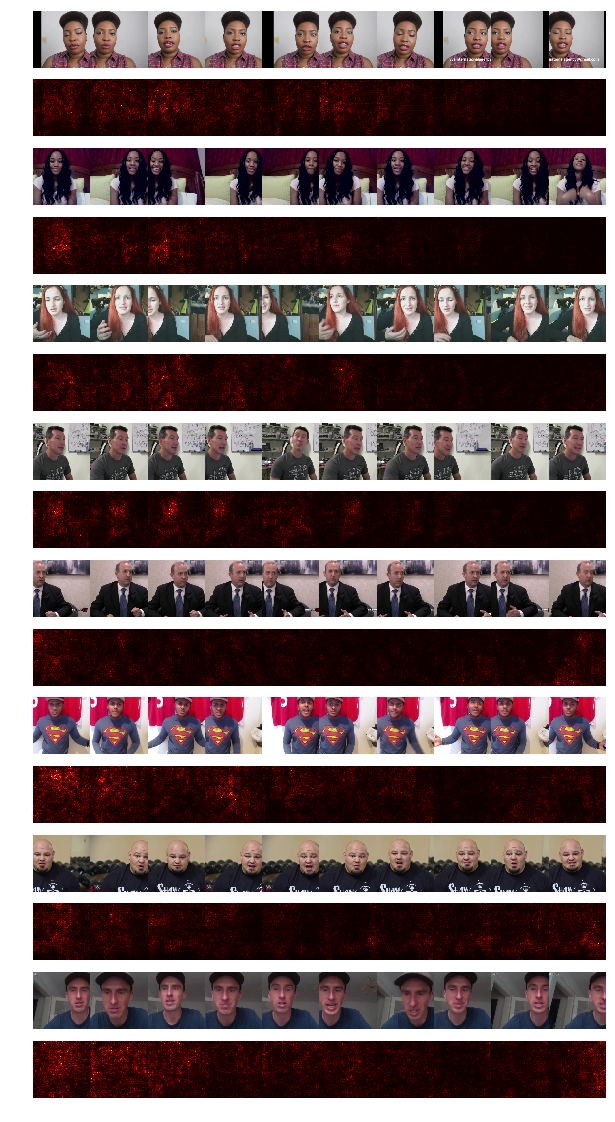

In [23]:
input_images,input_audio, target_var = lstmDataBaseAccess.returnSampleDataBatch()
compute_show_saliency_maps_lstm_justLoss(8, (input_images,input_audio, target_var))

IndexError: index 9 is out of bounds for axis 0 with size 8